In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import dask.dataframe as dd
import dask


In [2]:
%matplotlib inline
%autosave 60

Autosaving every 60 seconds


In [3]:
cluster = PBSCluster(
    cores=1,
    memory="120GB",
    project='pangeo',
    processes=1,
    walltime='04:00:00',
    local_directory='$TMPDIR')
cluster

/home/ad/alberta/git/conda-pack/pytide/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41831 instead
  http_address["port"], self.http_server.port


PBSCluster('tcp://10.120.43.22:38818', workers=0, threads=0, memory=0 B)

In [4]:
cluster.scale(40)

In [5]:
client = Client(cluster) # scheduler_file="/home/ad/briolf/scheduler.json")
client

Client Scheduler: tcp://10.120.43.22:38818 Dashboard: http://10.120.43.22:41831/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [11]:
print(len(client.scheduler_info()["workers"]))

8


In [9]:
!qstat -u albert7a

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 30:
        break
    time.sleep(1)
print(nb_workers)

34


In [12]:
import zarr
import netCDF4
import pytide
import xarray as xr
import os
import glob
import numpy as np

In [13]:
%%time
root = "/work/ALT/odatis/eNATL60/BLBT02/gridT-2D/"
files = sorted(glob.glob(root+'/*.nc'))

drop_vars = [
    'nav_lat',
    'nav_lon',
    'somxl010',
    'sosaline',
    'sosstsst']

# these are variables I want to drop while running `open_mfdataset` but then add back later
extra_coord_vars = ['y', 'x']
extra_coord_vars = []

chunks = dict(time_counter=1)

open_kwargs = dict(drop_variables=(drop_vars + extra_coord_vars),
                   chunks=chunks, decode_cf=True, concat_dim="time_counter") #, combine='nested')
ds = xr.open_mfdataset(files, combine='nested',parallel=True, **open_kwargs)


CPU times: user 4.6 s, sys: 190 ms, total: 4.79 s
Wall time: 9.89 s


In [14]:
dsg=xr.open_dataset('/work/ALT/odatis/eNATL60/mesh_mask_eNATL60_3.6_lev1.nc4')

In [15]:
box=(-90,-60,30,45)
domaineNATL60=(box[0]<dsg.nav_lon)*(dsg.nav_lon<box[1])*(box[2]<dsg.nav_lat)*(dsg.nav_lat<box[3])
whereeNATL60=np.where(domaineNATL60)
jmineNATL60 = whereeNATL60[0].min()
jmaxeNATL60 = whereeNATL60[0].max()
imineNATL60 = whereeNATL60[1].min()
imaxeNATL60 = whereeNATL60[1].max()

START_DATE = np.datetime64('2009-07-01')
END_DATE = np.datetime64('2010-07-01')
time_series=ds['time_counter']
period = (time_series >= START_DATE) & (time_series <= END_DATE)
time=time_series[period]
ssh=ds.sossheig[period,jmineNATL60:jmaxeNATL60+1,imineNATL60:imaxeNATL60+1]
t=time.values

In [43]:
t

array(['2009-07-01T00:30:00.000000000', '2009-07-01T01:30:00.000000000',
       '2009-07-01T02:30:00.000000000', ...,
       '2010-06-30T21:30:00.000000000', '2010-06-30T22:30:00.000000000',
       '2010-06-30T23:30:00.000000000'], dtype='datetime64[ns]')

In [45]:
tt = t.astype('datetime64[s]')

In [46]:
tt

array(['2009-07-01T00:30:00', '2009-07-01T01:30:00',
       '2009-07-01T02:30:00', ..., '2010-06-30T21:30:00',
       '2010-06-30T22:30:00', '2010-06-30T23:30:00'],
      dtype='datetime64[s]')

In [16]:
%%time
wt = pytide.WaveTable()
wt = pytide.WaveTable(["M2"])
f, vu = wt.compute_nodal_modulations(t)

CPU times: user 9.62 ms, sys: 966 µs, total: 10.6 ms
Wall time: 10.8 ms


In [47]:
%%time
wtt = pytide.WaveTable()
wtt = pytide.WaveTable(["M2"])
ft, vut = wtt.compute_nodal_modulations(tt)

CPU times: user 7.68 ms, sys: 868 µs, total: 8.55 ms
Wall time: 11.5 ms


In [33]:
f

array([[0.98084399, 0.9808452 , 0.98084642, ..., 0.9923985 , 0.9923999 ,
        0.9924013 ]])

In [35]:
vu.shape

(1, 8760)

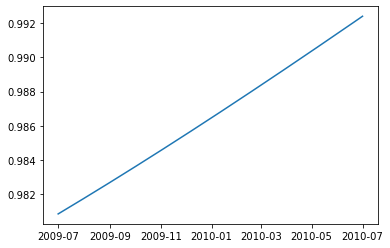

In [40]:
import matplotlib.pyplot as plt
plt.plot(t,f[0])

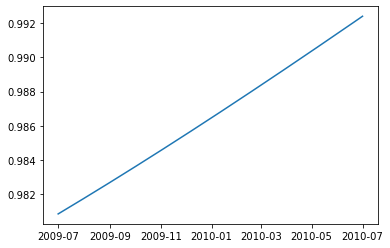

In [48]:
import matplotlib.pyplot as plt
plt.plot(t,ft[0])

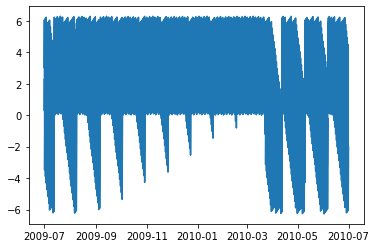

In [49]:
import matplotlib.pyplot as plt
plt.plot(t,vut[0])

In [17]:
def dask_array_rechunk(da, axis=0):
    """Search for the optimal block cutting without modifying the axis 'axis'
    in order to optimize its access in memory."""
    nblocks = 1
    
    def calculate_chuncks_size(chunks, size):
        result = np.array(chunks).prod() * size
        return result / (1000**2)
       
    while True:
        chunks = []
        div = int(np.sqrt(nblocks))
        for index, item in enumerate(da.chunks):
            chunks.append(np.array(item).sum() * (div if index == axis else 1))
        chunks = tuple(item // div for index, item in enumerate(chunks))
        chuncks_size = calculate_chuncks_size(chunks, da.dtype.itemsize)
        if chuncks_size > 100 and chuncks_size < 150:
            return chunks
        nblocks += 1

In [18]:
def _apply_along_axis(arr, func1d, func1d_axis, func1d_args, func1d_kwargs):
    """Wrap apply_along_axis"""
    return np.apply_along_axis(func1d, func1d_axis, arr, *func1d_args,
                                  **func1d_kwargs)


def apply_along_axis(func1d, axis, arr, *args, **kwargs):
    """Apply the harmonic analysis to 1-D slices along the given axis."""
    arr = dask.array.core.asarray(arr)

    # Validate and normalize axis.
    arr.shape[axis]
    axis = len(arr.shape[:axis])

    # Rechunk so that analyze is applied over the full axis.
    arr = arr.rechunk(arr.chunks[:axis] + (arr.shape[axis:axis + 1], ) +
                      arr.chunks[axis + 1:])

    # Test out some data with the function.
    test_data = np.ones(args[0].shape[1], dtype=arr.dtype)
    test_result = np.array(func1d(test_data, *args, **kwargs))

    # Map analyze over the data to get the result
    # Adds other axes as needed.
    result = arr.map_blocks(
        _apply_along_axis,
        name=dask.utils.funcname(func1d) + '-along-axis',
        dtype=test_result.dtype,
        chunks=(arr.chunks[:axis] + test_result.shape + arr.chunks[axis + 1:]),
        drop_axis=axis,
        new_axis=list(range(axis, axis + test_result.ndim, 1)),
        func1d=func1d,
        func1d_axis=axis,
        func1d_args=args,
        func1d_kwargs=kwargs,
    )

    return result

In [19]:
ssh_rechunk = ssh.chunk(dask_array_rechunk(ssh))
future = apply_along_axis(pytide.WaveTable.harmonic_analysis, 0, ssh_rechunk,
                          *(f, vu))


In [20]:
len(future.dask)

70427

In [21]:
%%time
analysis = future.compute()

CPU times: user 6min 6s, sys: 12.6 s, total: 6min 18s
Wall time: 23min 32s


In [22]:
analysis.shape

(1, 1290, 1825)

In [25]:
nwaves, ni, nj = analysis.shape


In [26]:
truc=analysis.reshape(nwaves, ni*nj)

In [27]:
truc.shape

(1, 2354250)

In [29]:
tttime=time[0].astype('datetime64[s]').astype('float64')

In [30]:
tttime

<xarray.DataArray 'time_counter' ()>
array(1.2464082e+18)
Coordinates:
    time_centered  datetime64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time_counter   datetime64[ns] 2009-07-01T00:30:00

In [50]:
nt=len(time)
nwaves, ni, nj = analysis.shape
k=0
test_ttide = wt.tide_from_mapping(time[k].astype('datetime64[s]').astype('float64'),analysis.reshape(nwaves, ni*nj)).reshape(ni, nj)


In [51]:
test_ttide

array([[        nan,         nan,         nan, ..., -0.22644822,
        -0.22630475, -0.22616975],
       [        nan,         nan,         nan, ..., -0.22641527,
        -0.226281  , -0.22615504],
       [        nan,         nan,         nan, ..., -0.22637347,
        -0.22624992, -0.22612754],
       ...,
       [        nan,         nan,         nan, ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ..., -0.24089038,
         0.        , -0.24073166]])

In [52]:
total_ssh=ssh[0]
detided_ssh=total_ssh-test_ttide

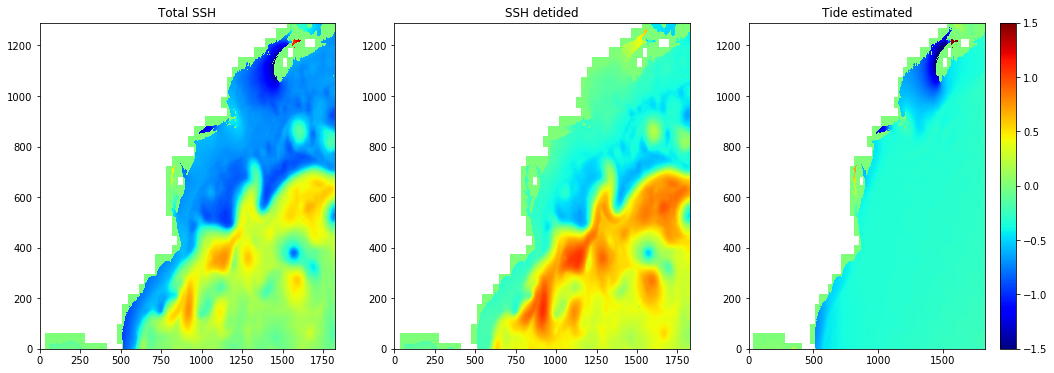

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.pcolormesh(total_ssh, vmin=-1.5, vmax=1.5,cmap='jet')
ax1.set_title("Total SSH")
ax2.pcolormesh(detided_ssh, vmin=-1.5, vmax=1.5, cmap='jet')
ax2.set_title("SSH detided")
pcolor=ax3.pcolormesh(test_ttide, vmin=-1.5, vmax=1.5, cmap='jet')
ax3.set_title("Tide estimated")
fig.colorbar(pcolor)

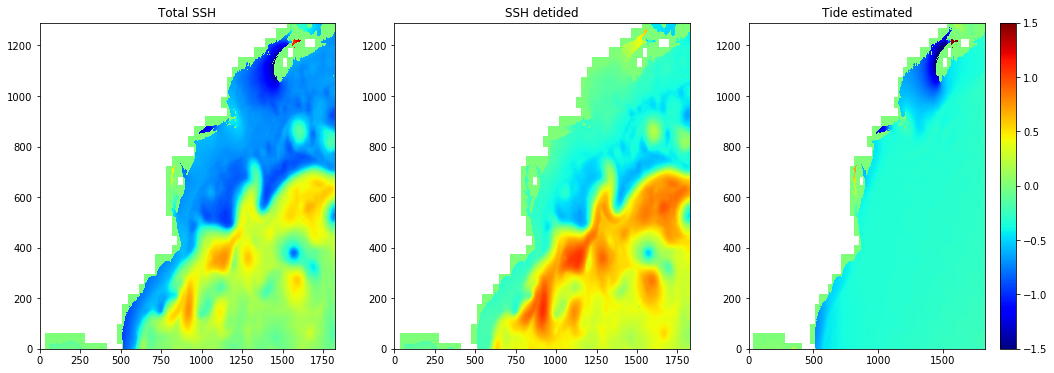

In [54]:
nt=len(time)
nwaves, ni, nj = analysis.shape
k=0
test_ttide = wt.tide_from_mapping(time[k].astype('datetime64[s]'),analysis.reshape(nwaves, ni*nj)).reshape(ni, nj)
total_ssh=ssh[0]
detided_ssh=total_ssh-test_ttide
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.pcolormesh(total_ssh, vmin=-1.5, vmax=1.5,cmap='jet')
ax1.set_title("Total SSH")
ax2.pcolormesh(detided_ssh, vmin=-1.5, vmax=1.5, cmap='jet')
ax2.set_title("SSH detided")
pcolor=ax3.pcolormesh(test_ttide, vmin=-1.5, vmax=1.5, cmap='jet')
ax3.set_title("Tide estimated")
fig.colorbar(pcolor)

In [83]:
%%time
nt=len(time)
nwaves, ni, nj = analysis.shape
for k in np.arange(len(time)):
    if not os.path.exists('/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tide-direct_time_M2_y2009m07-y2010m06_k'+str(k)+'.nc'):
        ttide = f[0,k] * (np.real(analysis[0]) * np.cos(vu[0,k]) + np.imag(analysis[0]) * np.sin(vu[0,k]))
        ttide_da=xr.DataArray(ttide,dims={'y','x'},name='tide')
        ttide_newcoord = ttide_da.assign_coords(time_counter=time[k])
        ttide_da_expanded = ttide_newcoord.expand_dims('time_counter')
        ttide_da_expanded.to_netcdf(path='/work/ALT/odatis/eNATL60/outputs/pytide/eNATL60GS-BLBT02_tide-direct_time_M2_y2009m07-y2010m06_k'+str(k)+'.nc',engine='scipy')


CPU times: user 15min 51s, sys: 1min 35s, total: 17min 27s
Wall time: 21min 28s


In [ ]:
cluster.close()

In [61]:
np.imag(analysis[0])

array([[        nan,         nan,         nan, ..., -0.13039215,
        -0.13058775, -0.13083298],
       [        nan,         nan,         nan, ..., -0.13044825,
        -0.13063457, -0.1308771 ],
       [        nan,         nan,         nan, ..., -0.13049369,
        -0.13067591, -0.13091731],
       ...,
       [        nan,         nan,         nan, ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ...,  0.        ,
         0.        ,  0.        ],
       [        nan,         nan,         nan, ..., -0.09871652,
         0.        , -0.10147243]])

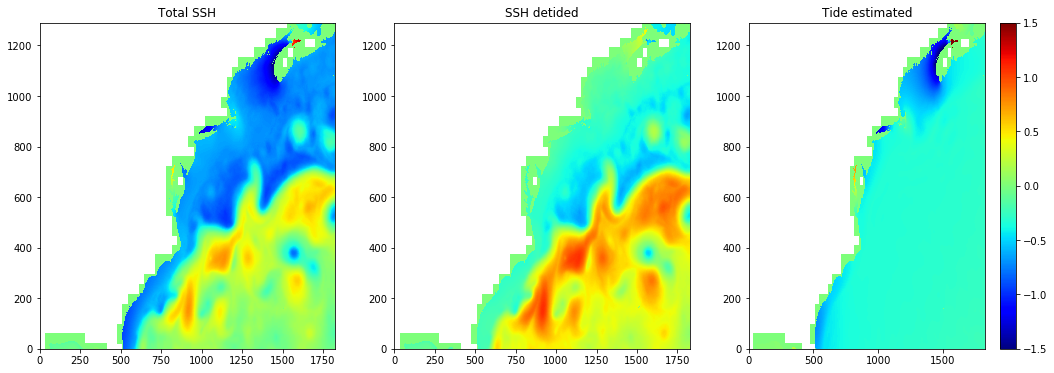

In [67]:
tide_direct=f[0,0] * (np.real(analysis[0]) * np.cos(vu[0,0]) + np.imag(analysis[0]) * np.sin(vu[0,0]))

total_ssh=ssh[0]
detided_ssh=total_ssh-tide_direct
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.pcolormesh(total_ssh, vmin=-1.5, vmax=1.5,cmap='jet')
ax1.set_title("Total SSH")
ax2.pcolormesh(detided_ssh, vmin=-1.5, vmax=1.5, cmap='jet')
ax2.set_title("SSH detided")
pcolor=ax3.pcolormesh(tide_direct, vmin=-1.5, vmax=1.5, cmap='jet')
ax3.set_title("Tide estimated")
fig.colorbar(pcolor)


In [65]:
f.shape

(1, 8760)

In [68]:
tide_one_point=f[0,:] * (np.real(analysis[0,400,1500]) * np.cos(vu[0,:]) + np.imag(analysis[0,400,1500]) * np.sin(vu[0,:]))


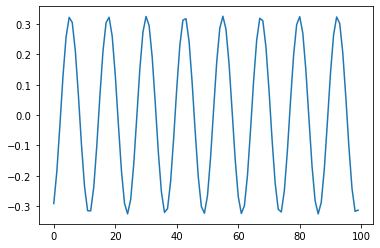

In [76]:
plt.plot(tide_one_point[0:100])

In [82]:
tide_all_point=f[0,:] * (np.real(analysis[0].reshape(ni*nj)) * np.cos(vu[0,:]) + np.imag(analysis[0].reshape(ni*nj)) * np.sin(vu[0,:]))


ValueError: operands could not be broadcast together with shapes (2354250,) (8760,) 

In [74]:
print(tide_one_point)

[-0.29192479 -0.18491675 -0.03158815 ... -0.2507772  -0.11545585
  0.04878668]


In [81]:
nwaves, ni, nj = analysis.shape
nt=len(time)
tide_all_points=np.zeros([nt,nj,ni])
for j in np.range(nj):
    for i in np.range(ni):
        tide_one=f[0,:] * (np.real(analysis[0,nj,ni]) * np.cos(vu[0,:]) + np.imag(analysis[0,nj,ni]) * np.sin(vu[0,:]))
        tide_all_points[:,nj,ni]=tide_one


MemoryError: Unable to allocate 154. GiB for an array with shape (8760, 1825, 1290) and data type float64

In [79]:
f[0].shape

(8760,)

In [80]:
nt

(8760,)